In [1]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

path = 'C:/Users/Pando/SCRIPTS JUPYTER/Projets/Projet 7/'

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(path + 'application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(path + 'application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                'EXT_SOURCE_3']].mean(axis=1)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(path + 'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(path + 'bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(path + 'previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(path + 'POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(path + 'installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(path + 'credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [2]:
# LightGBM GBDT with KFold or Stratified KFold
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc')

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [3]:
def main_df(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    return df

Train samples: 307511, test samples: 48744


C:\Users\Pando\AppData\Local\Temp\ipykernel_22300\3615707156.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(test_df).reset_index()


Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 33s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 24s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 8s
Installments payments df shape: (339587, 26)
Process installments payments - done in 16s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 16s
Starting LightGBM. Train shape: (307507, 799), test shape: (48744, 799)
Fold  1 AUC : 0.778997
Fold  2 AUC : 0.773969
Fold  3 AUC : 0.781367
Fold  4 AUC : 0.775532
Fold  5 AUC : 0.779240
Fold  6 AUC : 0.781471
Full AUC score 0.778388


C:\Users\Pando\AppData\Local\Temp\ipykernel_22300\3284389425.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['TARGET'] = sub_preds


Run LightGBM with kfold - done in 3589s
Full model run - done in 3690s


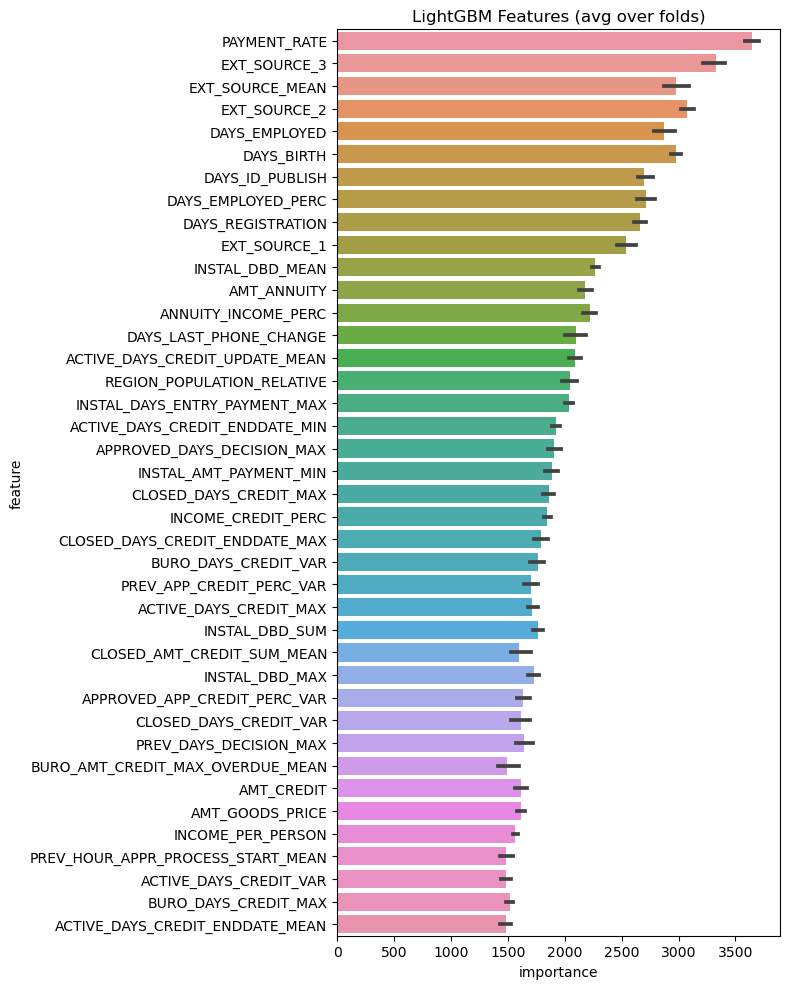

In [4]:
def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 6, stratified= False, debug= debug)

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        main()

In [4]:
main = main_df()
main

Train samples: 307511, test samples: 48744


C:\Users\Pando\AppData\Local\Temp\ipykernel_11616\3615707156.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(test_df).reset_index()


Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 19s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 26s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 13s
Installments payments df shape: (339587, 26)
Process installments payments - done in 26s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 24s


,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356251,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356252,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356253,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Extraire les features intéressantes dans un autre df, puis missingno et EDA
main_eda = main[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_MEAN',
                 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC', 'DAYS_REGISTRATION',
                 'DAYS_ID_PUBLISH', 'AMT_ANNUITY', 'ANNUITY_INCOME_PERC',
                 'INSTAL_DBD_MEAN', 'DAYS_LAST_PHONE_CHANGE',
                 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN', 'REGION_POPULATION_RELATIVE',
                 'APPROVED_DAYS_DECISION_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
                 'INCOME_CREDIT_PERC', 'AMT_GOODS_PRICE', 'AMT_CREDIT', 'PAYMENT_RATE',
                 'TARGET']]
main_eda

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_MEAN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_REGISTRATION,DAYS_ID_PUBLISH,AMT_ANNUITY,...,DAYS_LAST_PHONE_CHANGE,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,REGION_POPULATION_RELATIVE,APPROVED_DAYS_DECISION_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INCOME_CREDIT_PERC,AMT_GOODS_PRICE,AMT_CREDIT,PAYMENT_RATE,TARGET
0,0.083037,0.262949,0.139376,0.161787,-9461,-637.0,0.067329,-3648.0,-2120,24700.5,...,-1134.0,-15.5,0.018801,-606.0,-49.0,0.498036,351000.0,406597.5,0.060749,1.0
1,0.311267,0.622246,NaN,0.466757,-16765,-1188.0,0.070862,-1186.0,-291,35698.5,...,-828.0,-43.0,0.003541,-746.0,-544.0,0.208736,1129500.0,1293502.5,0.027598,0.0
2,NaN,0.555912,0.729567,0.642739,-19046,-225.0,0.011814,-4260.0,-2531,6750.0,...,-815.0,NaN,0.010032,-815.0,-727.0,0.500000,135000.0,135000.0,0.050000,0.0
3,NaN,0.650442,NaN,0.650442,-19005,-3039.0,0.159905,-9833.0,-2437,29686.5,...,-617.0,NaN,0.008019,-181.0,-12.0,0.431748,297000.0,312682.5,0.094941,0.0
4,NaN,0.322738,NaN,0.322738,-19932,-3038.0,0.152418,-4311.0,-3458,21865.5,...,-1106.0,NaN,0.028663,-374.0,-14.0,0.236842,513000.0,513000.0,0.042623,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356250,NaN,0.648575,0.643026,0.645800,-19970,-5169.0,0.258838,-9094.0,-3399,17473.5,...,-684.0,-27.5,0.002042,-683.0,-599.0,0.294503,270000.0,412560.0,0.042354,NaN
356251,NaN,0.684596,NaN,0.684596,-11186,-1149.0,0.102718,-3015.0,-3003,31909.5,...,0.0,NaN,0.035792,-770.0,-56.0,0.253047,495000.0,622413.0,0.051267,NaN
356252,0.733503,0.632770,0.283712,0.549995,-15922,-3037.0,0.190742,-2681.0,-1504,33205.5,...,-838.0,-45.0,0.026392,-84.0,-33.0,0.642857,315000.0,315000.0,0.105414,NaN
356253,0.373090,0.445701,0.595456,0.471416,-13968,-2731.0,0.195518,-1461.0,-1364,25128.0,...,-2308.0,-22.5,0.018850,-577.0,-13.0,0.500000,450000.0,450000.0,0.055840,NaN


<AxesSubplot:>

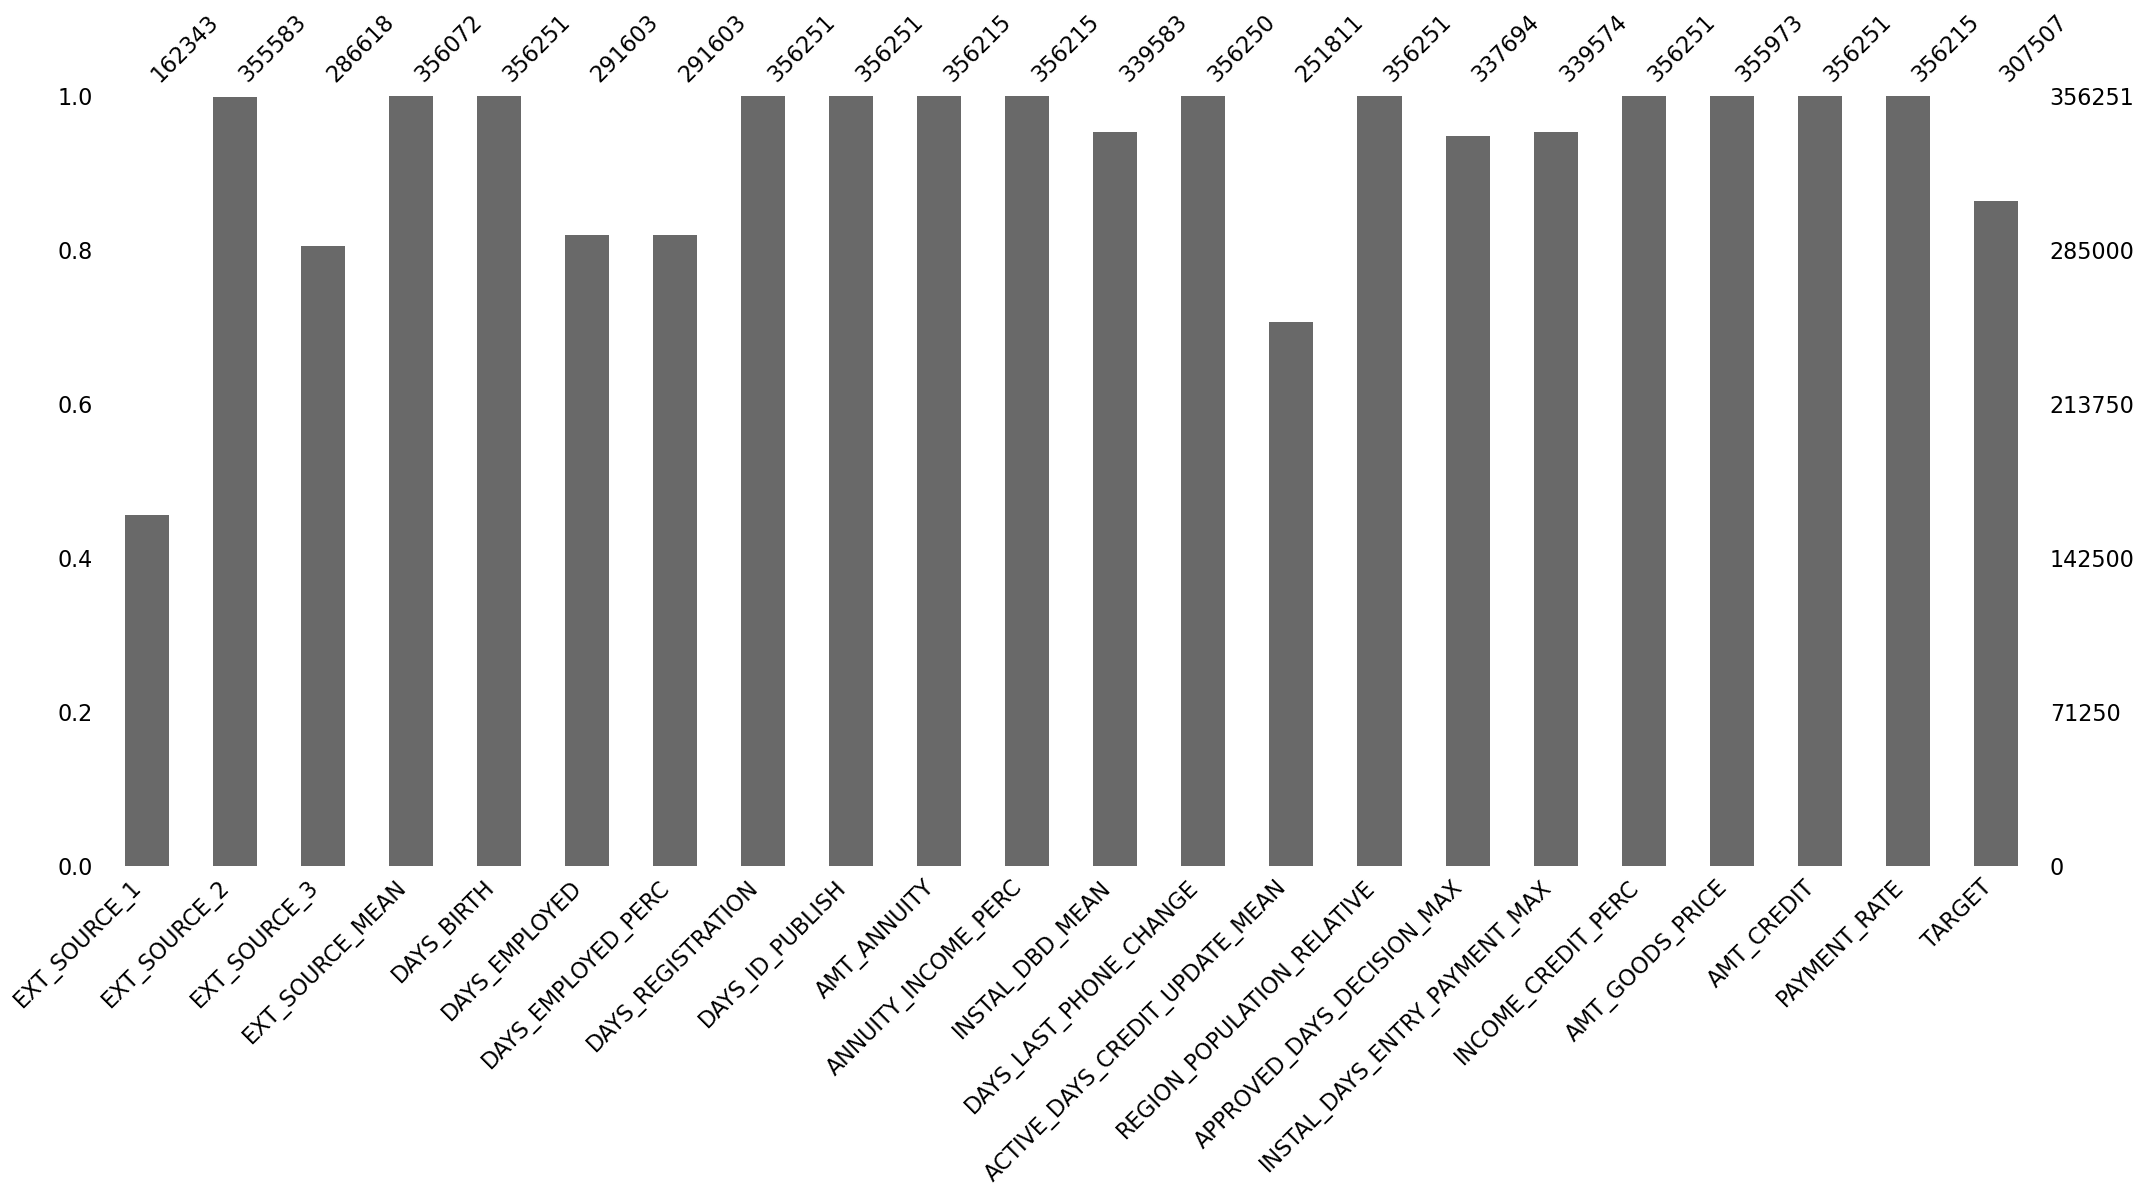

In [6]:
msno.bar(main_eda)

<function matplotlib.pyplot.show(close=None, block=None)>

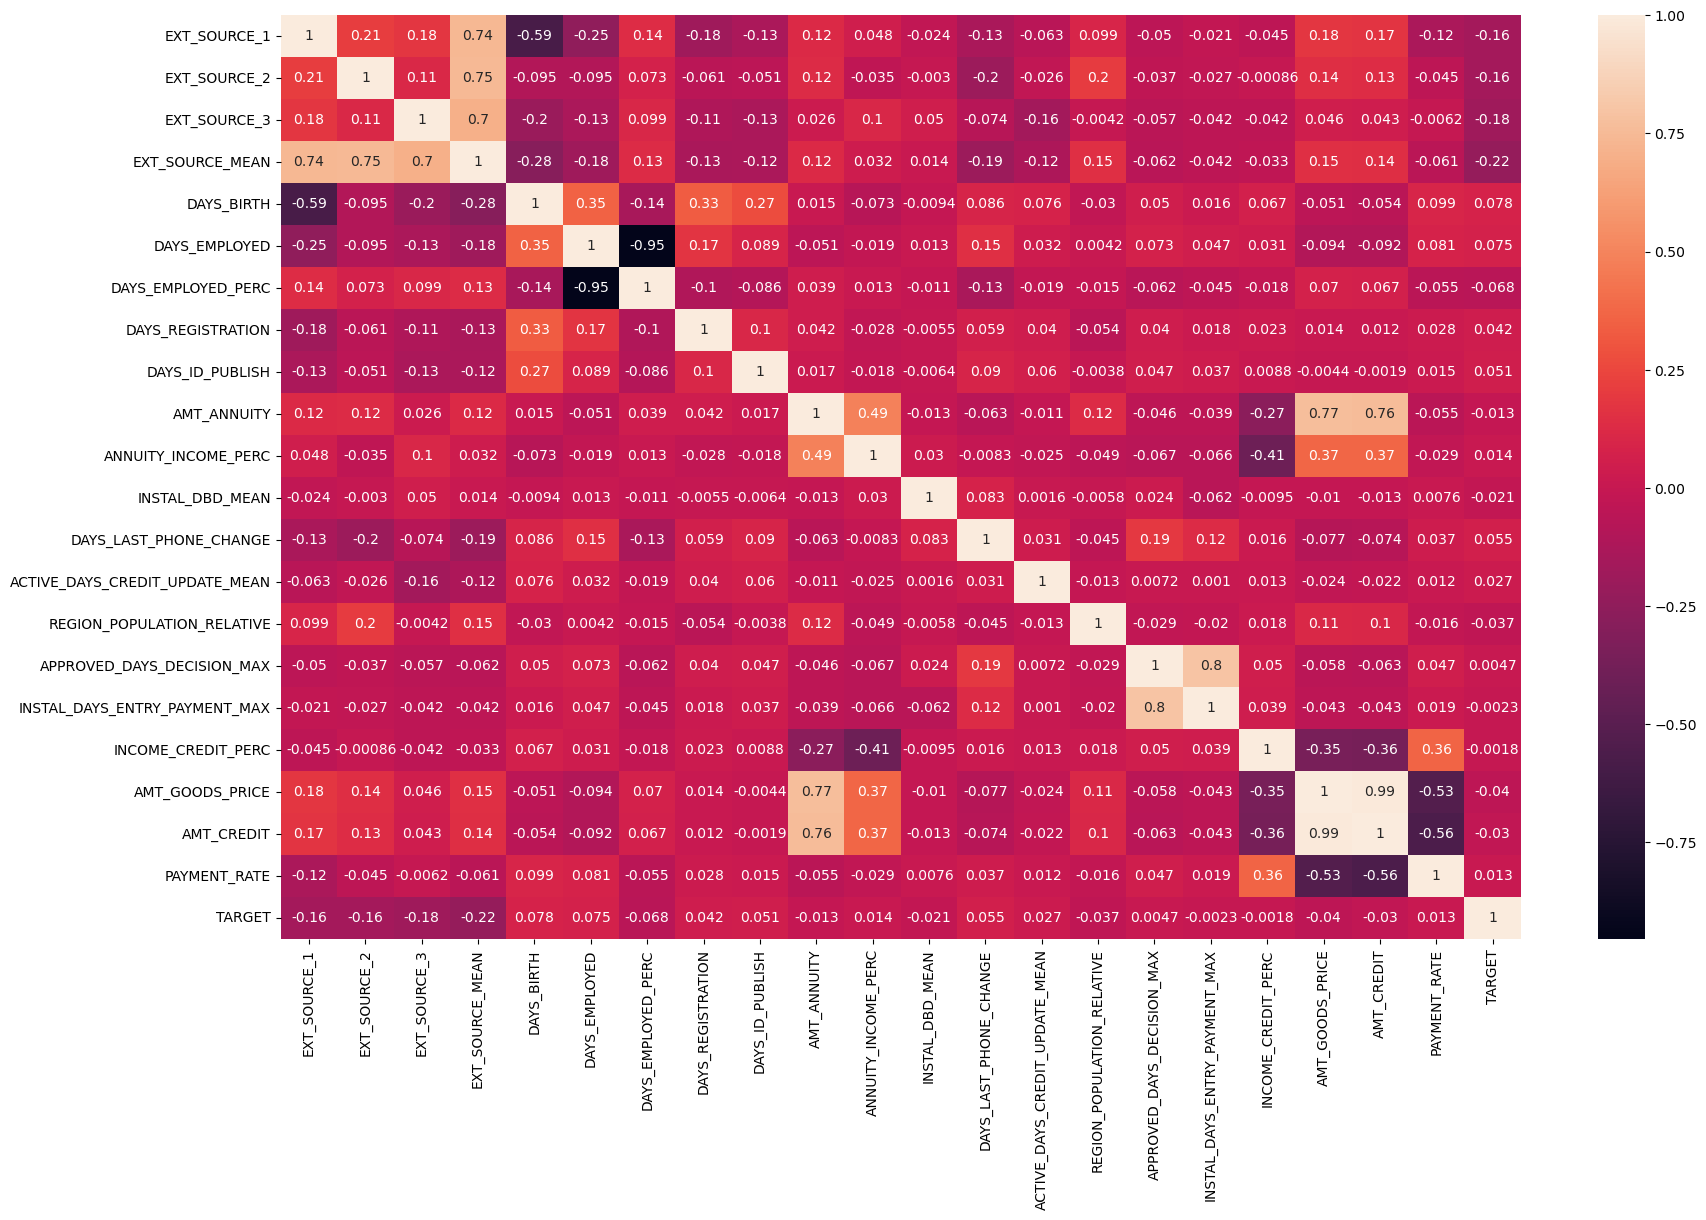

In [7]:
corr = main_eda.corr()

plt.figure(figsize=(20, 12))
sns.heatmap(corr, annot=True)
plt.show

In [8]:
main_eda.describe()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_MEAN,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED_PERC,DAYS_REGISTRATION,DAYS_ID_PUBLISH,AMT_ANNUITY,...,DAYS_LAST_PHONE_CHANGE,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,REGION_POPULATION_RELATIVE,APPROVED_DAYS_DECISION_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INCOME_CREDIT_PERC,AMT_GOODS_PRICE,AMT_CREDIT,PAYMENT_RATE,TARGET
count,162343.000000,3.555830e+05,286618.000000,356072.000000,356251.000000,291603.000000,291603.000000,356251.000000,356251.000000,356215.000000,...,356250.000000,251811.000000,356251.000000,337694.000000,339574.000000,356251.000000,3.559730e+05,3.562510e+05,356215.000000,307507.00000
mean,0.501964,5.148892e-01,0.509353,0.508940,-16041.276687,-2396.675703,0.157797,-4983.603036,-3002.070644,27425.644390,...,-978.582546,-129.283396,0.020917,-604.970763,-328.436694,0.411925,5.280212e+05,5.877695e+05,0.055463,0.08073
std,0.210046,1.897533e-01,0.194140,0.148478,4358.798530,2334.451895,0.133449,3526.966202,1517.905393,14732.860946,...,835.066531,287.844332,0.013915,561.992779,537.370145,0.496408,3.660657e+05,3.986253e+05,0.023206,0.27242
min,0.013458,8.173617e-08,0.000527,0.000006,-25229.000000,-17912.000000,-0.000000,-24672.000000,-7197.000000,1615.500000,...,-4361.000000,-41919.000000,0.000253,-2922.000000,-3071.000000,0.011801,4.050000e+04,4.500000e+04,0.022073,0.00000
25%,0.335501,3.949551e-01,0.368969,0.414119,-19676.000000,-3200.000000,0.056954,-7477.000000,-4318.000000,16731.000000,...,-1592.000000,-107.000000,0.010006,-736.000000,-387.000000,0.200000,2.340000e+05,2.700000e+05,0.038080,0.00000
50%,0.506155,5.648384e-01,0.533482,0.523827,-15755.000000,-1663.000000,0.120073,-4502.000000,-3252.000000,25078.500000,...,-771.000000,-30.000000,0.018850,-438.000000,-65.000000,0.316570,4.500000e+05,5.002110e+05,0.050000,0.00000
75%,0.673344,6.629285e-01,0.665855,0.621197,-12425.000000,-780.000000,0.220597,-1995.000000,-1717.000000,34960.500000,...,-286.000000,-16.500000,0.028663,-247.000000,-26.000000,0.500000,6.750000e+05,7.975575e+05,0.067066,0.00000
max,0.962693,8.549997e-01,0.896010,0.878903,-7338.000000,0.000000,0.728811,0.000000,0.000000,258025.500000,...,0.000000,372.000000,0.072508,-1.000000,-1.000000,208.003328,4.050000e+06,4.050000e+06,0.124430,1.00000


In [9]:
app_train = pd.read_csv('application_train.csv')

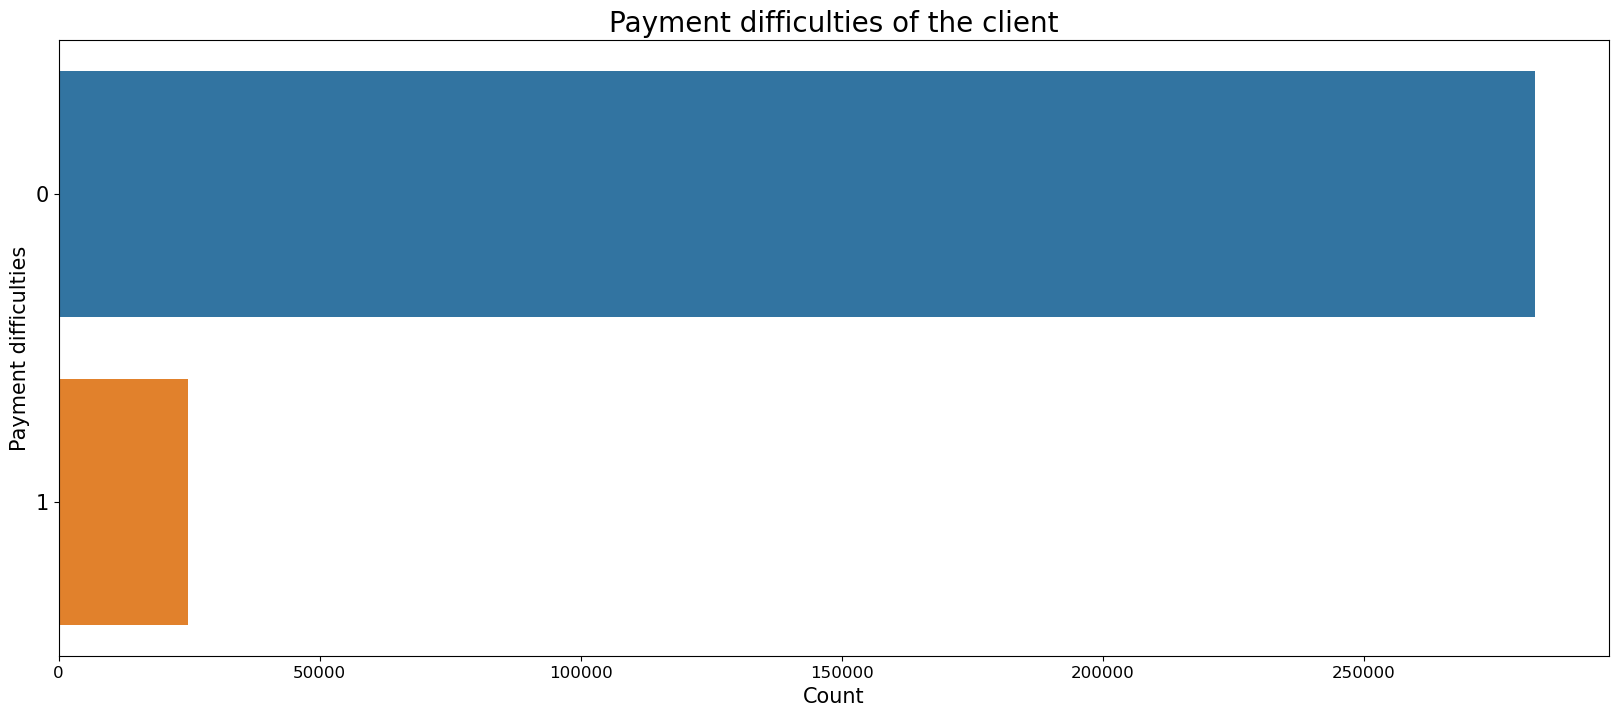

In [10]:
ax, fig = plt.subplots(figsize=(20,8)) 
ax = sns.countplot(y='TARGET', data=app_train)
ax.set_title("Target")

plt.xlabel('Count', fontsize=15)
plt.ylabel('Payment difficulties', fontsize=15)

plt.title('Payment difficulties of the client', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
plt.show()

In [11]:
def client_age():
    age = main_eda['DAYS_BIRTH']/-365
    
    plt.figure(figsize=(26, 14))
    sns.histplot(data=age, x=age.values, bins=20)
    plt.ylabel('Count', fontsize=25)
    plt.xlabel("Client's age", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('Distribution of clients ages', fontsize=40)

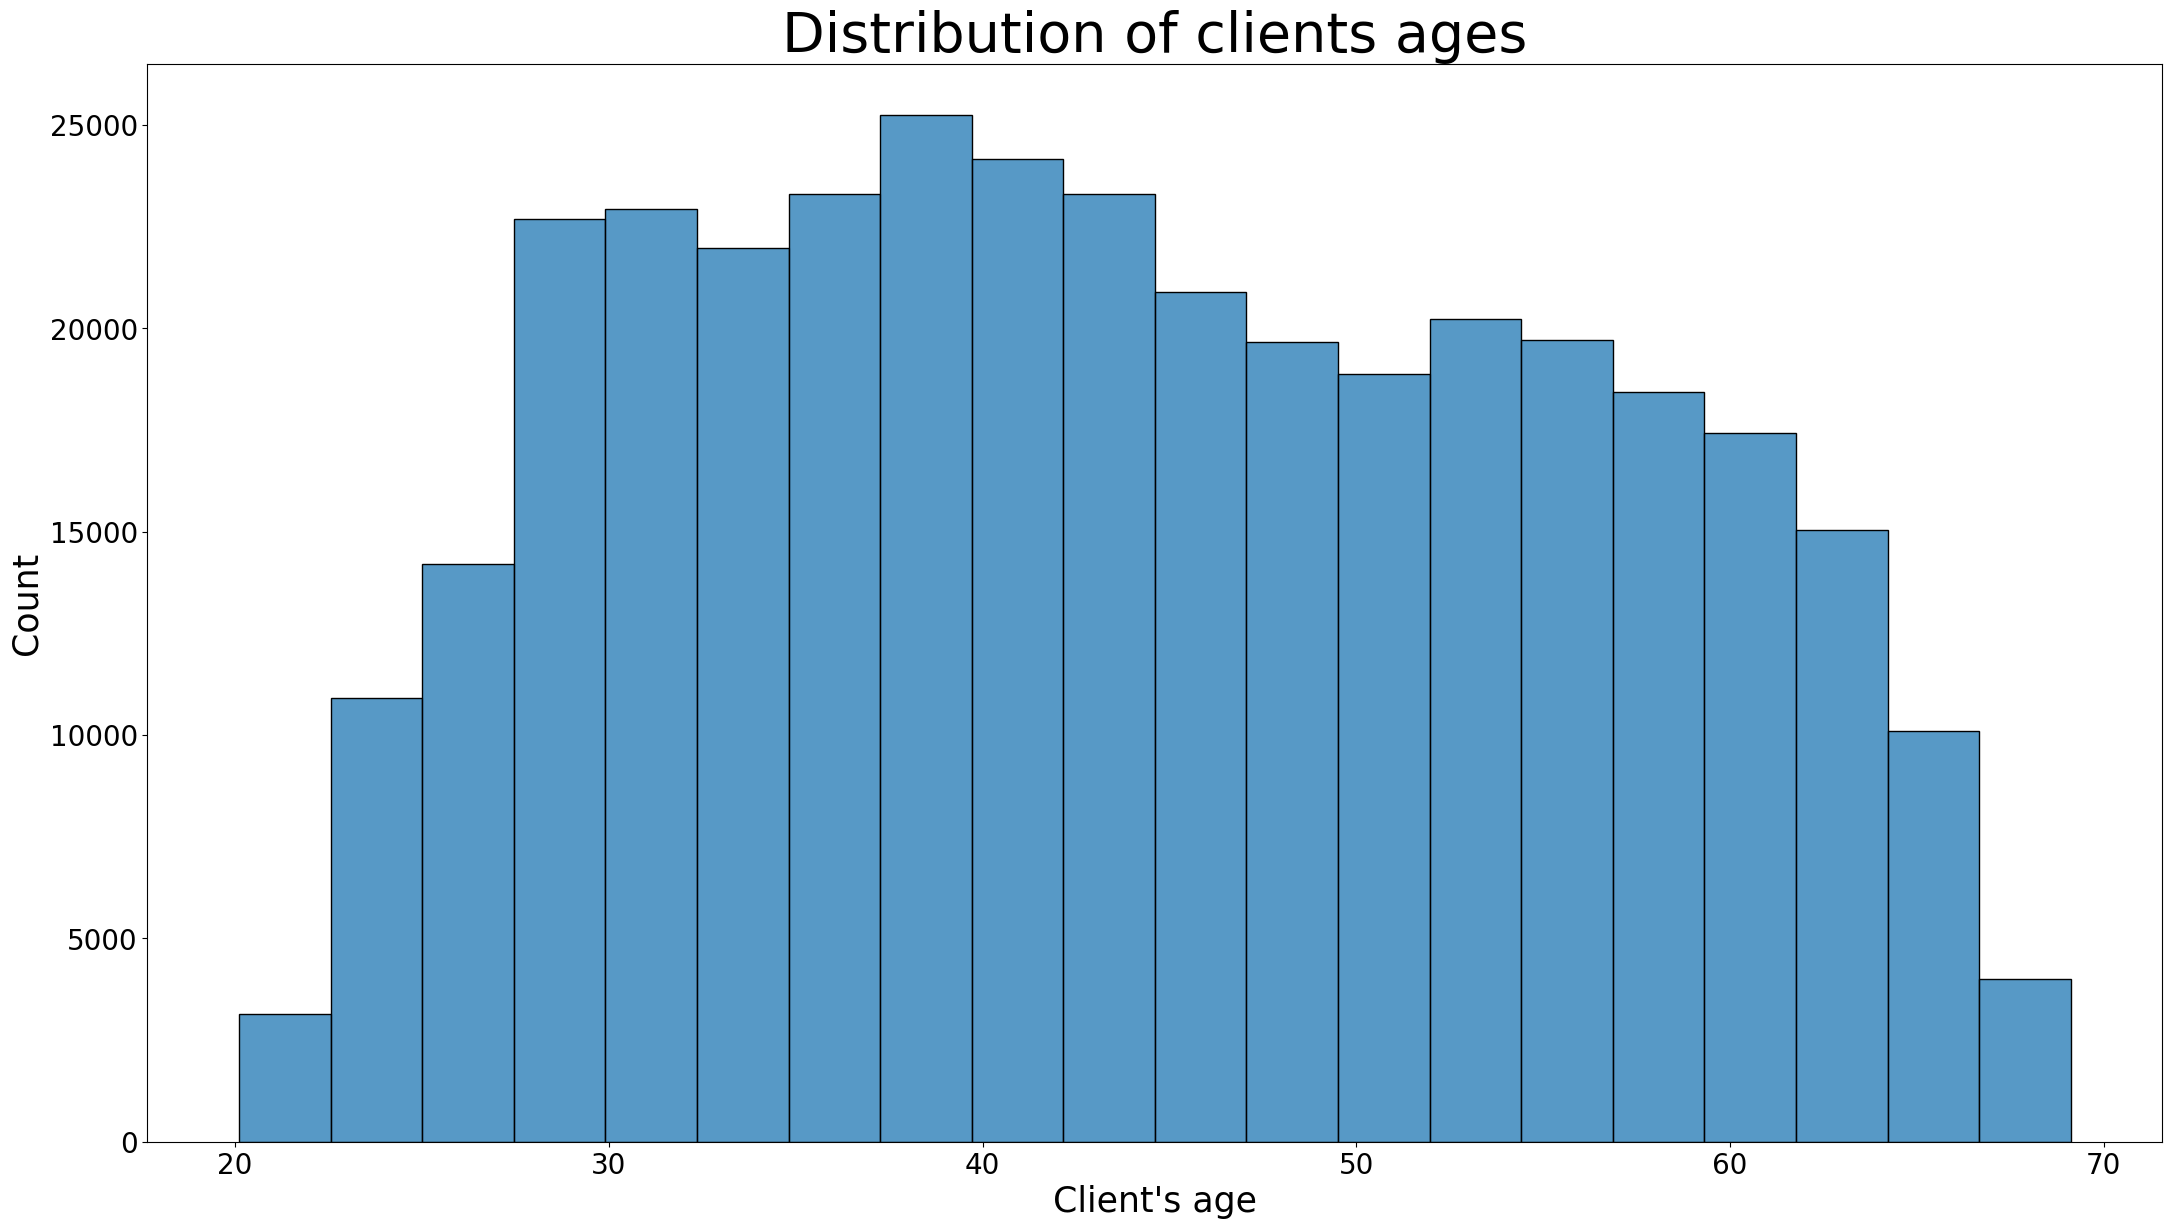

In [12]:
client_age()

In [13]:
#Combien des clients possèdent leur propre maison / appartement ou leur propre voiture ?
def car_and_realty():
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sns.countplot(y='FLAG_OWN_CAR', data=main)
    ax.set_title("Car Owners")
    
    plt.xlabel('Count', fontsize=15)
    plt.ylabel('Owns or not', fontsize=15)
    
    plt.title('Number of car owners', fontsize=20)
    plt.yticks([0, 1], ['No', 'Yes'], fontsize=15)
    plt.xticks(fontsize=12)
    plt.show()

    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sns.countplot(y='FLAG_OWN_REALTY', data=main)
    ax.set_title("Realty Owners")
    
    plt.xlabel('Count', fontsize=15)
    plt.ylabel('Owns or not', fontsize=15)
    
    plt.title('Number of realty owners', fontsize=20)
    plt.yticks([0, 1], ['No', 'Yes'], fontsize=15)
    plt.xticks(fontsize=12)
    plt.show()

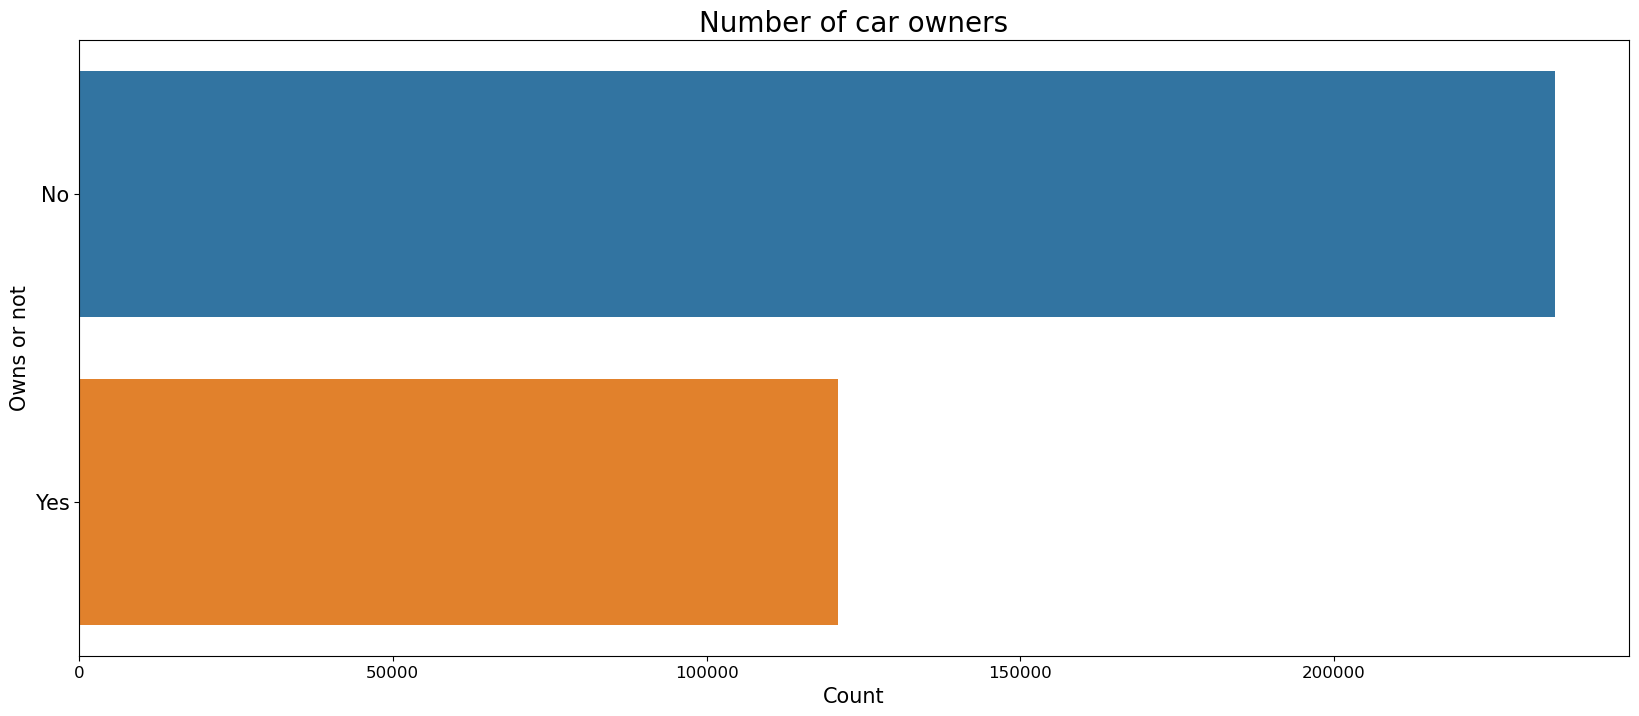

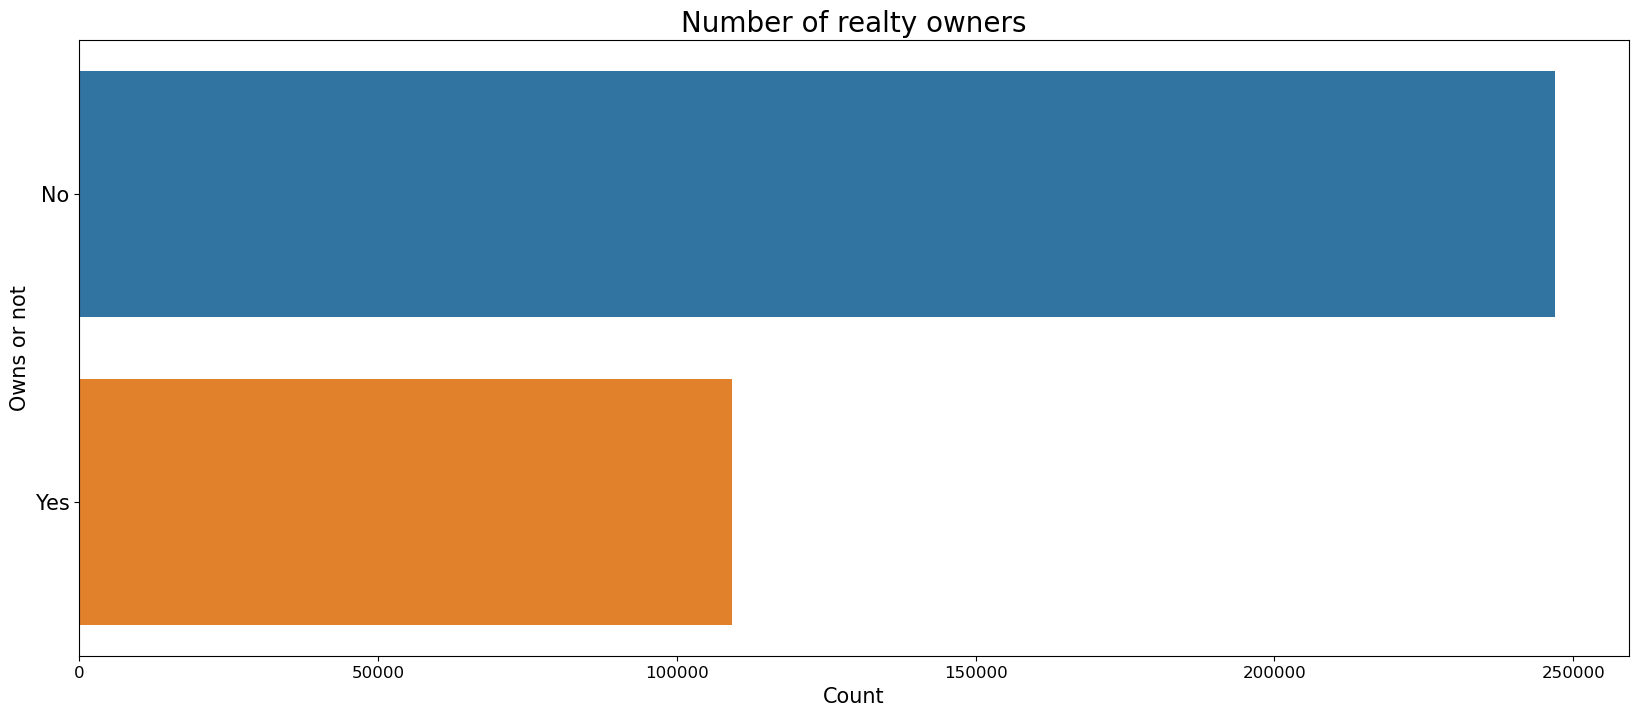

In [14]:
car_and_realty()

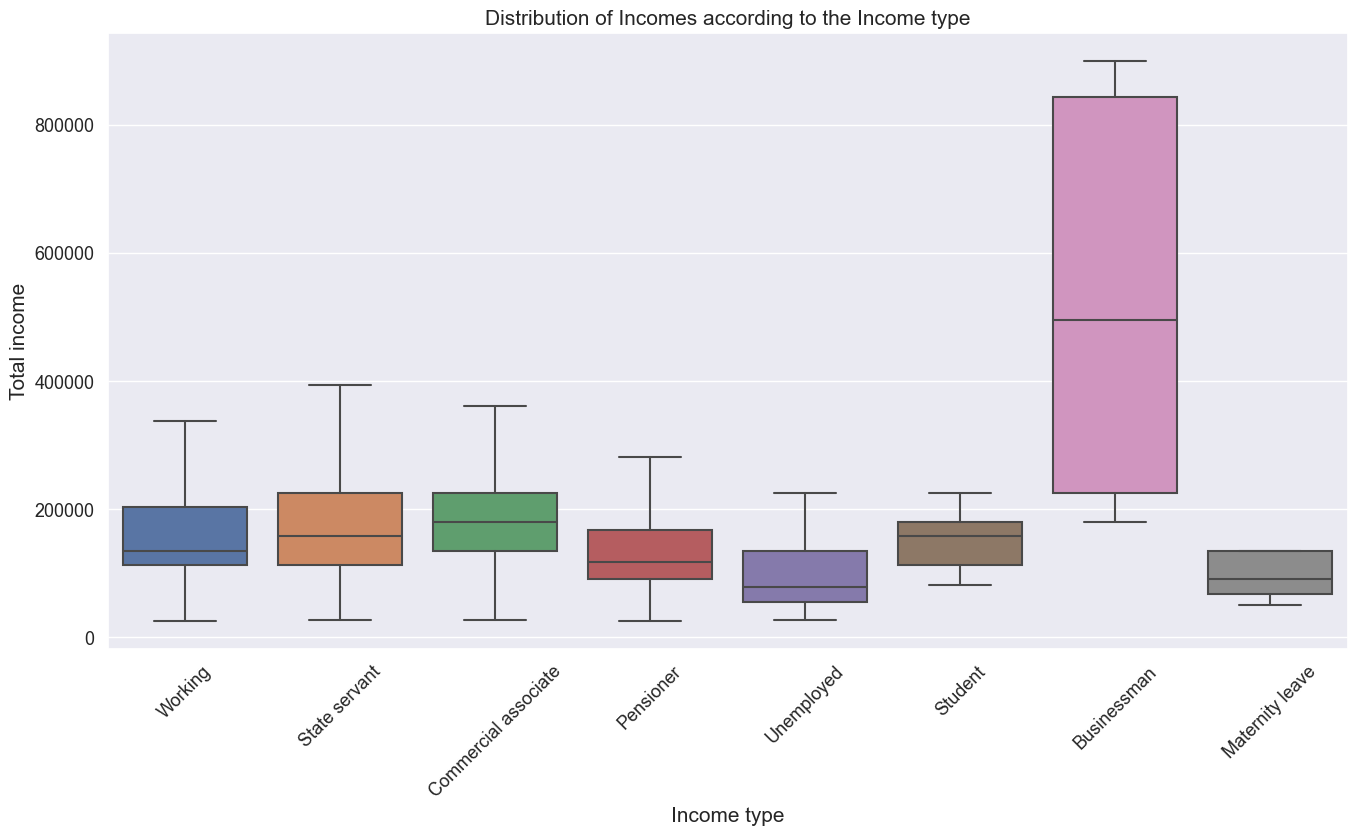

In [15]:
plt.figure(figsize=(16, 8))
sns.set_theme()
sns.boxplot(data=app_train, x='NAME_INCOME_TYPE',
            y='AMT_INCOME_TOTAL', showfliers = False)
plt.title('Distribution of Incomes according to the Income type', fontsize=15)
plt.xlabel('Income type', fontsize=15)
plt.ylabel('Total income', fontsize=15)
plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [16]:
main = main.drop(columns='index')
main.to_pickle('main.pkl')